This is a simple simulation of ideal particles moving under a centrifugal
force and was used to determine the settling behavior of HL-60s (and
primaries) in a linear gradient of Percoll.

In [1]:
using Unitful
using DataFrames
using Plots
using StatsPlots
using Measures
using Unitful: μm, g, mL, rpm, rad, s, mm, cP

Using diameter values from Jan 17th, 2018.

-  LatB treated day 5 HL-60s cells = 375μm^3
-  Same cells + stimulation = 450μm^3

In [2]:
diameters = ([375, 450] .* 3 ./ (4π)).^(1/3) .* 2

2-element Vector{Float64}:
 8.947002289396496
 9.507608651323626

Gradients range ≈ 1.048g/mL-1.080g/mL

Dmax = 1.075g/mL
Dmin = 1.0475g/mL

See `2022/220522_nutridoma_fractionation_repeat3/notebooks/Meta.ipynb`

In [3]:
Dmin = 1.04513g/mL
Dmax = 1.0744g/mL

1.0744 g mL^-1

Values estimated from experiment on 2021-02-08 for HL-60s

In [4]:
stim_density = 1.050g/mL
unstim_density = 1.055g/mL

ω = uconvert(rad/s, 1100rpm)

r = 183.2u"mm"

η = 5cP # viscosity of Percoll from Sigma

η_water = 0.75cP # wikipedia @ 20C
η_percoll = 10.0cP # sigma unknown temp

η_min = 0.4 * η_percoll + 0.6 * η_water
η_max = 0.6 * η_percoll + 0.4 * η_water

function viscosity(vol::Unitful.Volume; dead_volume=0.5mL)
    if vol <= dead_volume
        return η_min
    else
        η_min + (vol-dead_volume)*(η_max-η_min)/10mL
    end
end

viscosity (generic function with 1 method)

  Unstimulated has to travel 29mm, stimulated has to travel 18mm. As measured
  by calipers.

  The height of the gradient is 55mm, from approximately 9.5mL mark to 1mL
  mark.

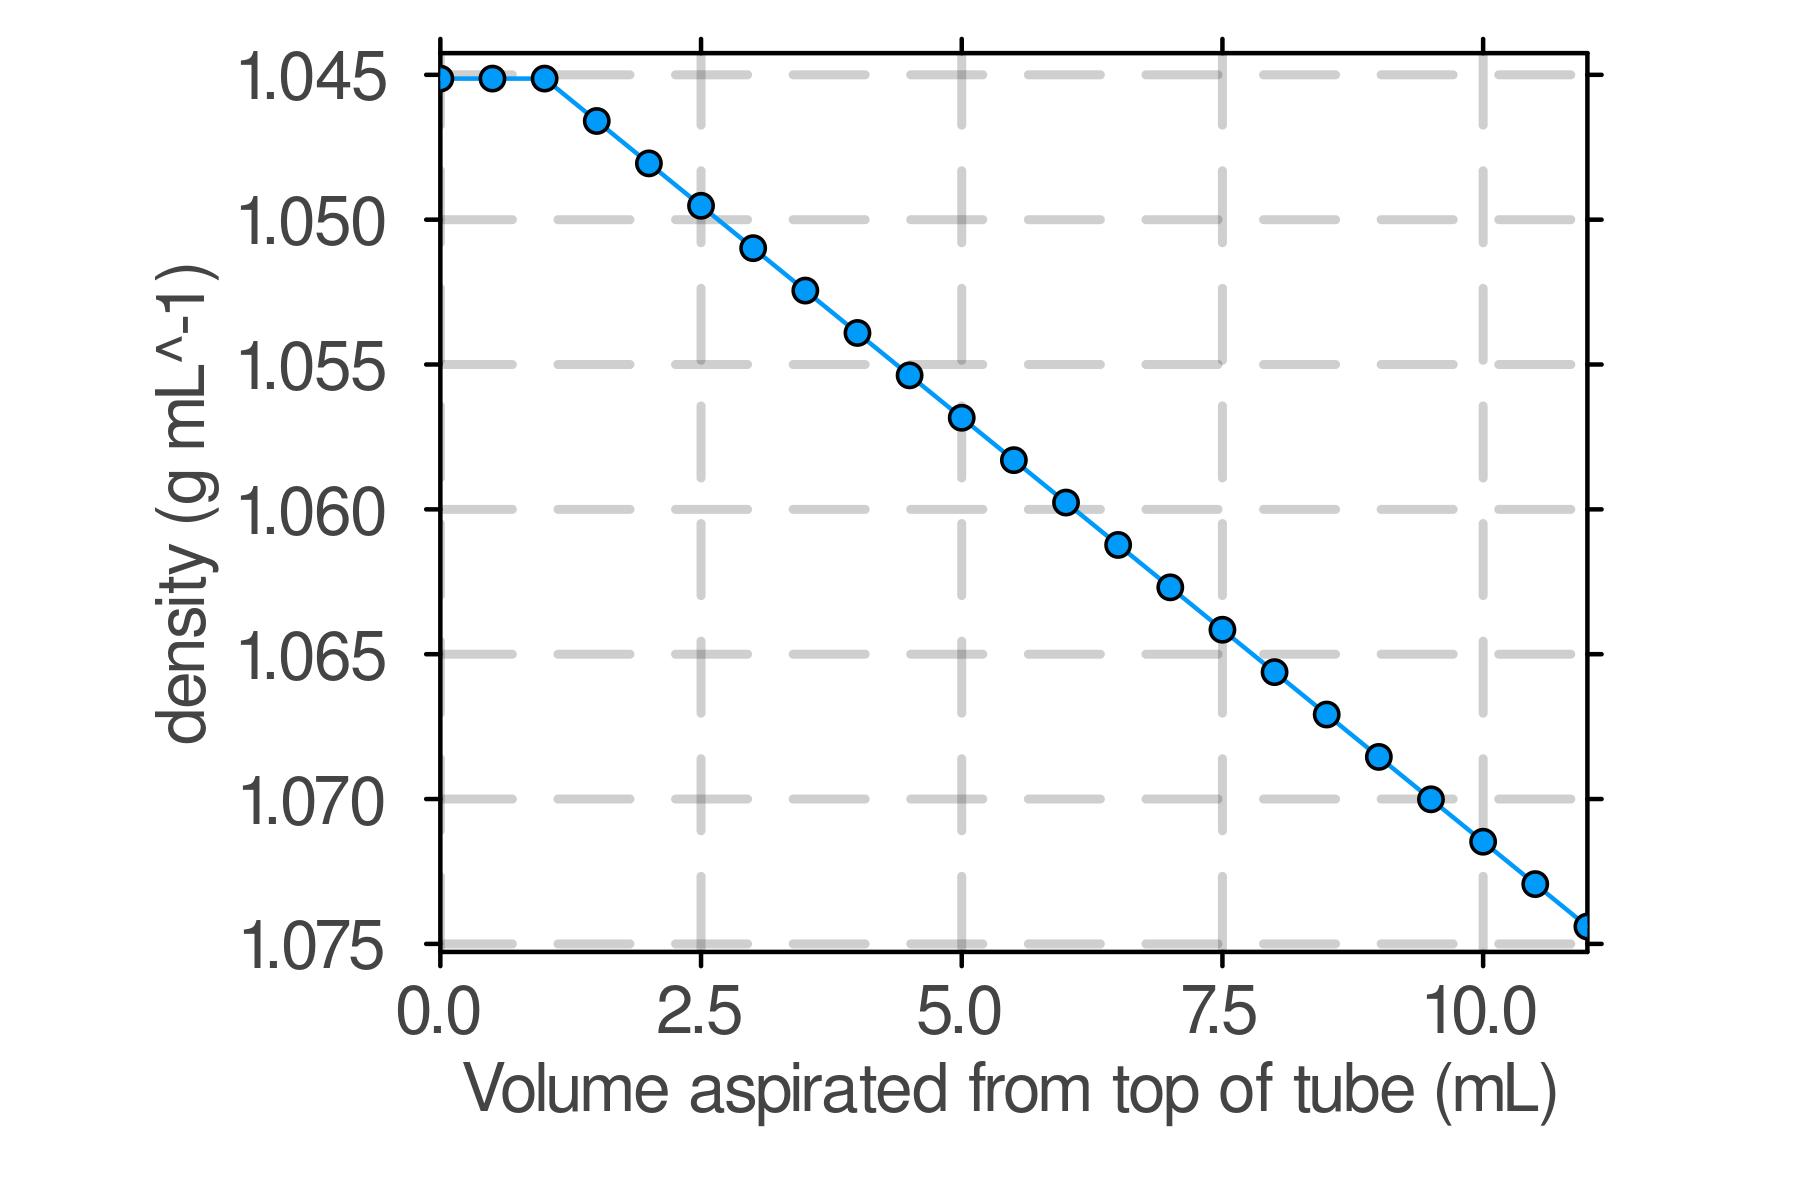

In [5]:
"""
The gradient is more accurately modeled at a linear gradient plus an initial
dead volume corresponding to the cell layer that I place on top of the gradient
"""
function density(vol::Unitful.Volume; dead_volume=0.5mL)
    if vol <= dead_volume
        Dmin
    else
        Dmin+(vol-dead_volume)*(Dmax-Dmin)/10mL
    end
end

default(
    guidefontsize=10, tickfontsize=10, titlefontsize=12,
    rightmargin=10 * Measures.mm, gridlinewidth=2, minorgridlinewidth=2, gridstyle=:dash,
    thickness_scaling=1.5, framestyle = :box, linewidth=1, dpi=300,
    fontfamily = "helvetica", palette = :auto)

xs = (0:0.5:11) .* mL
plot(xs, density.(xs, dead_volume=1mL), m = 3, xlim = (0mL, 11mL), label = "",
    xlabel = "Volume aspirated from top of tube", ylabel = "density", yflip = true)

  Empirical radius of Falcon #352051

  The distance between the 11mL and 2mL mark on the tube was 51.25mm measured
  using digital calipers

In [6]:
uconvert(mm, sqrt(9.0mL / 51.25mm / π ))

7.476518004805303 mm

This is the radius of the Falcon tube

In [7]:
distance(vol::Unitful.Volume) = uconvert(mm, vol/(π * (7.48mm)^2))

volume(dist::Unitful.Length) = uconvert(mL, π * (7.48mm)^2 * dist)

"""Calculate the density based on distance traveled in mm"""
density(dist) = density(uconvert(u"mL", π * (7.48mm) ^ 2 * dist))

Main.var"##315".density

My implementation of Harwood 1974 equation 1, reproduced below:

$$
V = \frac{a^2 \cdot (Dp - Dm) \cdot \omega^2 \cdot r}{18\eta}
$$

-  a = cell diameter
-  Dₚ = density of cell
-  Dₘ = density of media
-  ω = angular velocity
-  r = radius of rotor
-  η = viscosity of media

In [8]:
"""
    velocity(diameter, Dₚ, dist)

Computes the instanteous velocity of a particle with a given diameter and
density `Dₚ` at a distance travel in mm in the tube
"""
function velocity(diameter, Dₚ, dist::Unitful.Volume)
    uconvert(u"mm/minute", (diameter^2 * (Dₚ - density(dist)) * ω^2 * r) / (18*viscosity(dist)))
end

function getdistances(diameter, density, time::Unitful.Time)
    x = 0.0u"mm"
    xs = typeof(x)[]
    times = 0s:1s:uconvert(s, time)
    for t in times
        x += velocity(diameter, density, volume(x)) * 1.0u"s"
        push!(xs, x)
    end
    xs, times
end

getdistances (generic function with 1 method)

## Run simulation

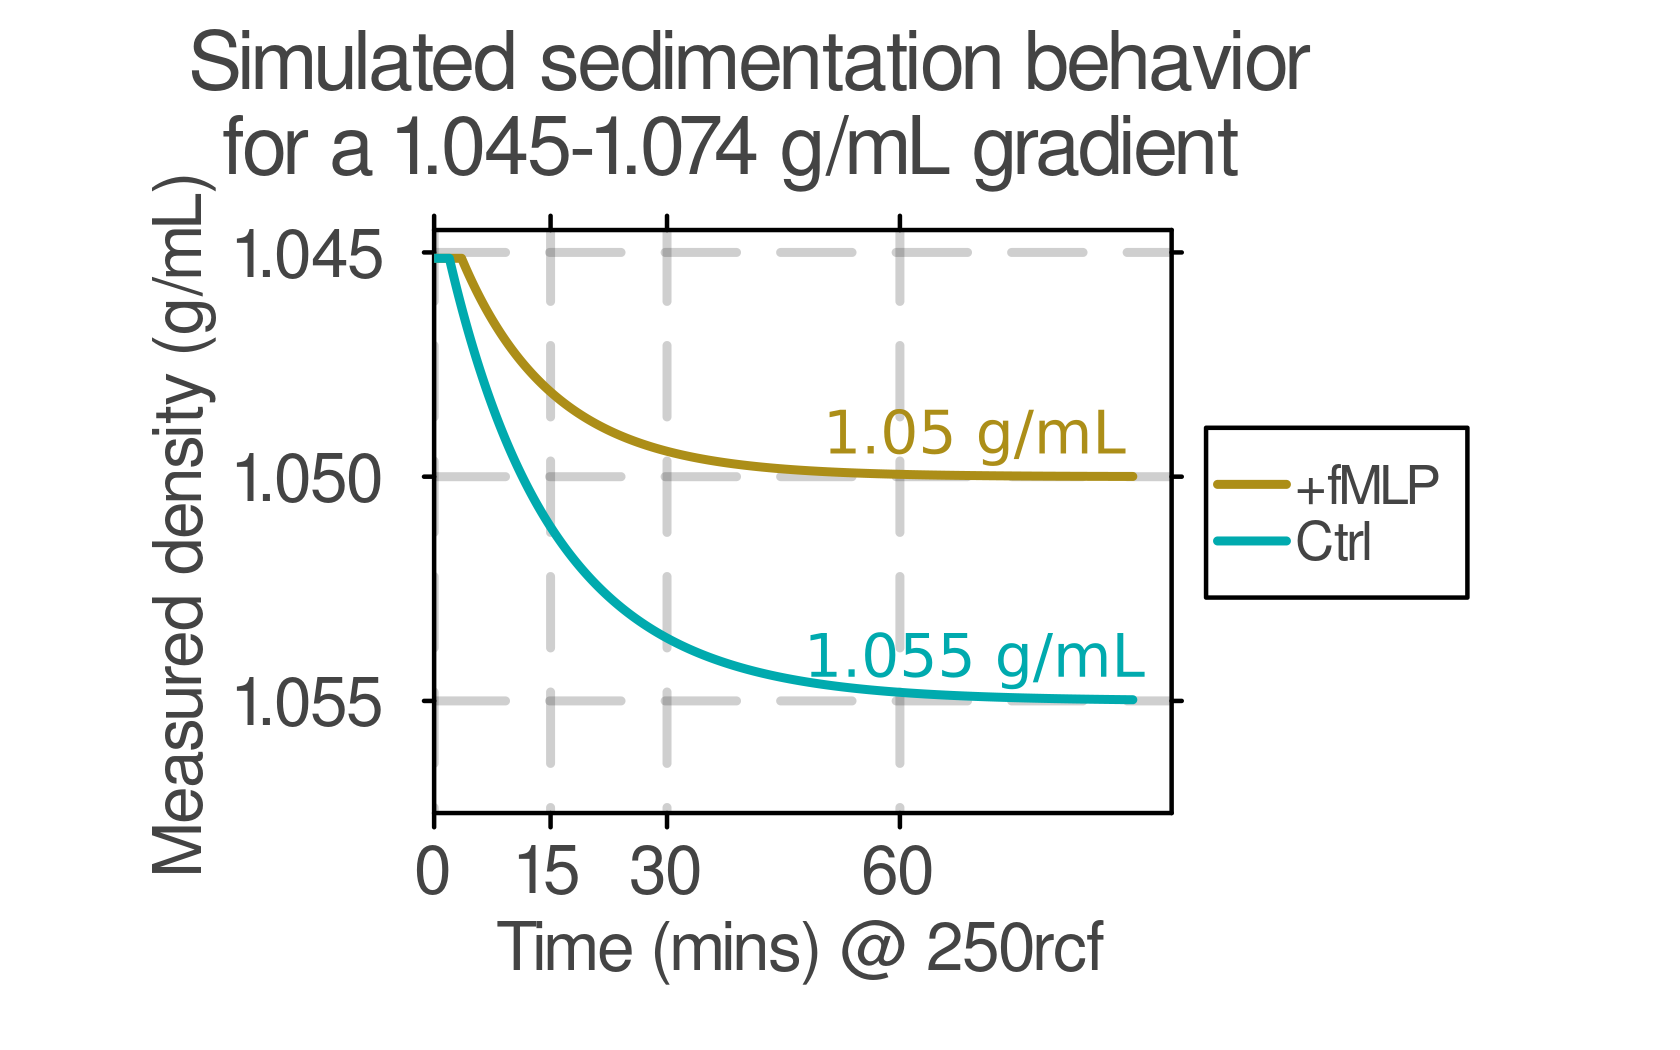

In [9]:
ω = uconvert(rad/s, 1100rpm)

res = getdistances(8.95μm, unstim_density, 90u"minute"), getdistances(9.5μm, stim_density, 90u"minute")
distances = vcat([r[1] for r in res]...)
times = vcat([r[2] for r in res]...)

simulated = DataFrame(
    sample = vcat(fill("Ctrl", length(res[1][1])), fill("+fMLP", length(res[2][1]))),
    times = ustrip.(uconvert.(u"minute", times)),
    distances = distances,
    volume = volume.(distances),
    density = density.(distances)
);

final = combine(groupby(simulated, :sample),
    :distances => last,
    :density => last)

p = @df simulated plot(:times, :density, group = :sample, yflip=true,
    title = "Simulated sedimentation behavior\nfor a $(round(ustrip(Dmin), sigdigits = 4))-$(round(ustrip(Dmax), sigdigits = 4)) g/mL gradient",
    xlabel = "Time (mins) @ $(Int(ustrip(round(u"ge", ω^2 * r, sigdigits = 2))))rcf",
    linewidth = 2, c = Plots.palette(:auto)[[5 6]], size = (560, 350), xlim = (0, 95), leg = :outerright,
    ylabel = P"Measured density (g/mL)", xticks=[0, 15, 30, 60], ylim = (1.0445, 1.0575), yticks = (1.045:0.005:1.055))

annotate!([70, 70], ustrip.(final.density_last) .- 0.001, text.(map(x->"$(round(x, sigdigits = 4)) g/mL", ustrip.(final.density_last)), 9, Plots.palette(:auto)[[6, 5]]))
savefig(p, "assets/density_grad_sim.svg") #hide
p

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*